# Collaborative Filtering

In [1]:
# for data manipulation
import numpy as np
import pandas as pd
import os

# use surprise for collaborative filtering
from surprise import Reader, Dataset
from surprise import SVD, evaluate
from surprise import NMF

# plotting 
import matplotlib.pyplot as plt

## Read in data

#### Game data

In [2]:
game_data_path = "data/final_game_data/"
files = os.listdir(game_data_path)
season = pd.read_csv(game_data_path + files[0])

In [3]:
season.shape

(2632, 98)

#### Odds data

In [4]:
odds_data_path = "data/odds_data_processed/"
odds_files = os.listdir(odds_data_path)

In [5]:
odds = pd.read_csv(odds_data_path + odds_files[1])

In [6]:
odds.shape

(1288, 14)

#### Reconciling names

In [7]:
season_names = {'Golden State Warriors':'GSW',
                'Los Angeles Lakers': 'LAL',
                'San Antonio Spurs': 'SAS',
                'Cleveland Cavaliers': 'CLE',
                'Denver Nuggets': 'DEN',
                'Indiana Pacers': 'IND',
                'Memphis Grizzlies': 'MEM',
                'New Jersey Nets': 'BRK',
                'Brooklyn Nets': 'BRK',
                'New Orleans Hornets': 'NOP',
                'New Orleans Pelicans': 'NOP',
                'Orlando Magic': 'ORL',
                'Toronto Raptors': 'TOR',
                'Miami Heat': 'MIA',
                'Seattle SuperSonics': 'SEA',
                'Utah Jazz': 'UTA',
                'Atlanta Hawks': 'ATL',
                'Boston Celtics': 'BOS',
                'Charlotte Bobcats': 'CHA',
                'Charlotte Hornets': 'CHA',
                'Chicago Bulls': 'CHI',
                'Los Angeles Clippers': 'LAC',
                'Minnesota Timberwolves': 'MIN',
                'Phoenix Suns': 'PHO',
                'Dallas Mavericks': 'DAL',
                'Houston Rockets': 'HOU',
                'Milwaukee Bucks': 'MIL',
                'Philadelphia 76ers': 'PHI',
                'Washington Wizards': 'WAS',
                'Detroit Pistons': 'DET',
                'New York Knicks': 'NYK',
                'Sacramento Kings': 'SAC',
                'Portland Trail Blazers': 'POR',
                'Oklahoma City Thunder': 'OKC'
        }
odds_names = {}
for name in list(pd.unique(odds.Home)):
    found = False
    for s_name in season_names:
        if name in s_name:
            found = True
            odds_names[name] = season_names[s_name]
    if not found: print(name)
odds_names["LA Lakers"] = "LAL"
odds_names["LA Clippers"] = "LAC"
odds_names["Okla City"] = "OKC"

LA Lakers
LA Clippers


In [8]:
odds["Home"] = odds["Home"].apply(lambda x: odds_names[x])
odds["Away"] = odds["Away"].apply(lambda x: odds_names[x])

season["team"] = season["team"].apply(lambda x: season_names[x])
season["opponent"] = season["opponent"].apply(lambda x: season_names[x])

#### Merging the two data tables

In [9]:
def make_index(row, col1, col2, col3):
    return str(row[col1]) + str(row[col2]) + str(row[col3])

season["date"] = season["date"].apply(lambda x: str(x)[:-1])

season["Index"] = season.apply(lambda x: make_index(x, "date", "team", "opponent"), axis=1)

odds["Date"] = odds["Date"].apply(lambda x: "".join(x.split("-")))

odds["Index"] = odds.apply(lambda x: make_index(x, "Date", "Home", "Away"), axis=1)

merged = pd.merge(odds, season, on='Index')

merged = merged.drop(["Unnamed: 0_x", "Unnamed: 0_y", "date", "Home", "Away", "index"], axis = 1)

In [10]:
merged.sample(1)

,Date,OU,Spread,OU_2H,Spread_2H,ML_home,ML_away,Points,Win Margin,2H Points,...,opponent_HOB,opponent_STL,opponent_TRB,opponent_FTA,opponent_BLK,opponent_FTr,opponent_TS%,opponent_FT/FGA,opponent_3P%,home
1200,20080419,188.5,3.0,95,3,-175,155,179,7,87,...,1.484848,4.0,42.0,17.0,3.0,0.207,0.480554,0.170732,0.25,1


In [11]:
in_data = merged.set_index("Index")
#data = data.drop(["index"], axis = 1)
in_data = in_data.sort_index()

In [12]:
in_data.shape

(1285, 106)

In [13]:
in_data.head(5)

,Date,OU,Spread,OU_2H,Spread_2H,ML_home,ML_away,Points,Win Margin,2H Points,...,opponent_HOB,opponent_STL,opponent_TRB,opponent_FTA,opponent_BLK,opponent_FTr,opponent_TS%,opponent_FT/FGA,opponent_3P%,home
Index,,,,,,,,,,,,,,,,,,,,,
20071030GSWUTA,20071030,214.5,3.0,105.5,3.0,-120,100,213,-21,100,...,1.585366,9.0,56.0,36.0,7.0,0.400,0.552721,0.333333,0.454545,1
20071030LALHOU,20071030,191.0,2.5,99,3,190,-230,188,-2,102,...,1.676471,10.0,49.0,31.0,5.0,0.419,0.541990,0.283784,0.272727,1
20071030SASPOR,20071030,184.0,12.5,95,5,-1400,900,203,9,95,...,1.384615,1.0,40.0,17.0,4.0,0.218,0.567384,0.166667,0.461538,1
20071031BRKCHI,20071031,188.0,2.0,94,3,-125,105,215,9,95,...,1.605263,7.0,45.0,26.0,3.0,0.271,0.479337,0.197917,0.347826,1
20071031CLEDAL,20071031,186.0,3.0,91.5,4.0,120,-140,166,-18,78,...,1.696970,6.0,36.0,20.0,8.0,0.290,0.591260,0.246377,0.500000,1


## Collaborative filtering (without team features)

In [14]:
dates = pd.unique(in_data.Date)
prev_games = 7
algo = SVD()

In [15]:
def train_model(train):
    
    algo = SVD()
    
    ratings_dict = {'userID': list(train.team),
                    'itemID': list(train.opponent),
                    'rating': list(train.Points)}
    df = pd.DataFrame(ratings_dict)

    # A reader is still needed but only the rating_scale param is required.
    # The Reader class is used to parse a file containing ratings.
    reader = Reader(rating_scale=(75, 280))

    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
    
    train = data.build_full_trainset()
    algo.fit(train)
    
    return algo
    

In [16]:
def test_model(test, algo, verbose=False): 
    users = test.team
    items = test.opponent
    labels = test.Points
    OU = test.OU

    mse = 0
    errors = 0
    num_bets = 0

    for i in range(len(users)):
        user = users[i]
        item = items[i]
        label = labels[i]
        ou = OU[i]
        
        pred = algo.predict(user, item, label).est
        
        if np.abs(pred - ou) > 4:
            num_bets += 1
            if (pred - ou)*(label - ou) < 0: errors += 1
        

        mse += (label - pred)**2
        
    if verbose: print("MSE: {}".format(mse/len(users)))
        
    return mse, len(users), errors, num_bets

In [17]:
mses = []
errors = []
choices = [i for i in range(1, 20)]

for prev_games in choices:
    mse = 0
    num_tests = 0
    err = 0
    num_bets = 0
    for i, date in enumerate(dates):
        if i < prev_games: continue

        window = dates[i - prev_games:i]

        window_data = in_data.loc[in_data['Date'].isin(window)]
        test_window = in_data.loc[in_data['Date'].isin(dates[i:i + 1])]

        model = train_model(window_data)
        cur_se, cur_tests, cur_errors, cur_bets = test_model(test_window, model)

        mse += cur_se
        num_tests += cur_tests
        err += cur_errors
        num_bets += cur_bets
        
    mses.append(mse/num_tests)
    errors.append(err/num_bets)

    print("Looking at the last {} days, the MSE is: {} (on {} tests)".format(prev_games, mse/num_tests, num_tests))

Looking at the last 1 days, the MSE is: 546.7635957446311 (on 1282 tests)
Looking at the last 2 days, the MSE is: 478.2186823028314 (on 1274 tests)
Looking at the last 3 days, the MSE is: 465.63568489371505 (on 1271 tests)
Looking at the last 4 days, the MSE is: 458.81993437255323 (on 1258 tests)
Looking at the last 5 days, the MSE is: 451.6434034813811 (on 1251 tests)
Looking at the last 6 days, the MSE is: 453.648219197661 (on 1243 tests)
Looking at the last 7 days, the MSE is: 448.7235394676829 (on 1242 tests)
Looking at the last 8 days, the MSE is: 454.92741668347145 (on 1234 tests)
Looking at the last 9 days, the MSE is: 453.5451659575558 (on 1225 tests)
Looking at the last 10 days, the MSE is: 453.7784678805422 (on 1222 tests)
Looking at the last 11 days, the MSE is: 460.93094605918617 (on 1209 tests)
Looking at the last 12 days, the MSE is: 462.40911825030713 (on 1204 tests)
Looking at the last 13 days, the MSE is: 459.0455998631002 (on 1198 tests)
Looking at the last 14 days, t

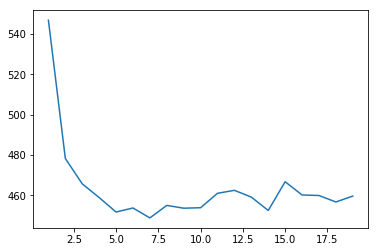

In [18]:
plt.plot(choices, mses)

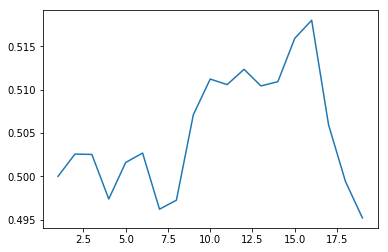

In [19]:
plt.plot(choices, errors)